# Weather Analysis and Prediction

### Import Libraries
Here we will use standard data science libraries for python including scikit-learn, numpy, pandas, and matplotlib.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
%matplotlib inline

### Provide your credentials to the runtime
This allows the colab access to underlying data stored in google cloud resources.

In [20]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Optional: Enable data table display
Colab includes the `google.colab.data_table` package the can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [3]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas datafram display, you can disable this by running:


```
%unload_ext google.colab.data_table
```



### Use BigQuery via magics to retrieve Park Weather Data
The `google.cloud.bigquery` library also includes a magic command which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

Load the query into a `Dataframe`

In [21]:
# Save output in a variable `weather_data`

%%bigquery weather_data --project sgcd-reportingengine-prj
SELECT
  location_id,
  instant,
  weather_condition_group,
  weather_condition_id,
  weather_summary,
  weather_clouds,
  CAST(weather_temperature AS INTEGER) weather_temperature,
  CAST(weather_humidity AS INTEGER) weather_humidity,
  CAST(weather_wind_speed AS INTEGER) weather_wind_speed,
  forecast_attendance,
  projected_attendance,
  budget_attendance,
  actual_attendance
FROM `sgcd-reportingengine-prj.test.vw_swc_weather_attendance`

Query is running:   0%|          |

Downloading:   0%|          |

Display the `Dataframe` content.

In [9]:
# display the `DataFrame` content.
weather_data

,location_id,instant,weather_condition_group,weather_condition_id,weather_summary,weather_clouds,weather_temperature,weather_humidity,weather_wind_speed,forecast_attendance,projected_attendance,budget_attendance,actual_attendance
0,1,2022-01-01,800,804,Clouds,100,55,73,10,16000,9200,12300,10388
1,1,2022-01-02,800,800,Clear,0,53,79,5,10000,9600,7900,9958
2,1,2022-01-03,800,800,Clear,0,51,74,2,3300,4000,3300,4652
3,1,2022-01-04,800,801,Clouds,20,51,77,3,3000,2600,3000,3157
4,1,2022-01-05,800,800,Clear,0,53,82,3,3100,3200,3100,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,1,2023-08-04,800,801,Clouds,20,66,84,5,15000,14800,15800,14466
580,1,2023-08-05,800,801,Clouds,20,68,85,7,21500,21800,23900,21638
581,1,2023-08-06,800,801,Clouds,20,66,90,6,22000,19500,17800,20570
582,1,2023-08-07,800,802,Clouds,40,66,88,3,12000,12700,13100,12408


### Adjust text features
With the data now loaded, we can move on to adjusting text columns into categories. The following step will convert forecast and actual weather text values such as `Clear` or `Rain` to numeric equivalents, and then apply that over the `Dataframe`.

`!DEPRECATED!` - After modifying the query for weather to include a group and identifier for the condition, this is no longer required.

In [10]:
#weather_category_dict = {'Clear':0, 'Partly Cloudy':1, 'Cloudy':2, 'Rain':3, 'None':np.nan}

#weather_data.Forecast_Weather = pd.Categorical(weather_data.Forecast_Weather, categories=weather_category_dict)
#weather_data['Forecast_Weather'] = weather_data.Forecast_Weather.cat.codes

#weather_data.Actual_Weather = pd.Categorical(weather_data.Actual_Weather, categories=weather_category_dict)
#weather_data['Actual_Weather'] = weather_data.Actual_Weather.cat.codes

weather_data

,location_id,instant,weather_condition_group,weather_condition_id,weather_summary,weather_clouds,weather_temperature,weather_humidity,weather_wind_speed,forecast_attendance,projected_attendance,budget_attendance,actual_attendance
0,1,2022-01-01,800,804,Clouds,100,55,73,10,16000,9200,12300,10388
1,1,2022-01-02,800,800,Clear,0,53,79,5,10000,9600,7900,9958
2,1,2022-01-03,800,800,Clear,0,51,74,2,3300,4000,3300,4652
3,1,2022-01-04,800,801,Clouds,20,51,77,3,3000,2600,3000,3157
4,1,2022-01-05,800,800,Clear,0,53,82,3,3100,3200,3100,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,1,2023-08-04,800,801,Clouds,20,66,84,5,15000,14800,15800,14466
580,1,2023-08-05,800,801,Clouds,20,68,85,7,21500,21800,23900,21638
581,1,2023-08-06,800,801,Clouds,20,66,90,6,22000,19500,17800,20570
582,1,2023-08-07,800,802,Clouds,40,66,88,3,12000,12700,13100,12408


### Shape the training data
We can now shape the appropriate input features and output values to prepare for training. You can uncomment one of the `feature_names`
declarations depending on which attendance projection you wish to analyze against.

Shape the input

In [23]:
#feature_names = ["Forecast_Weather", "Projected_Attendance"]
#feature_names = ["Forecast_Weather", "Forecasted_Attendance"]
#feature_names = ["Forecast_Weather", "Budget_Attendance"]
feature_names = ["weather_condition_group", "weather_clouds", "weather_temperature", "weather_humidity", "weather_wind_speed", "forecast_attendance"]
attendance_output_name = "actual_attendance"

X = weather_data[feature_names]
X.head()

,weather_condition_group,weather_clouds,weather_temperature,weather_humidity,weather_wind_speed,forecast_attendance
0,800,100,55,73,10,16000
1,800,0,53,79,5,10000
2,800,0,51,74,2,3300
3,800,20,51,77,3,3000
4,800,0,53,82,3,3100


Shape the output

In [24]:
y_attendance = weather_data[attendance_output_name]
y_attendance.head()

0    10388
1     9958
2     4652
3     3157
4     3751
Name: actual_attendance, dtype: Int64

### Split Training and Test Data
The next step is to properly split our training data into samples for training and verification or testing. The command below will select random samples of training data and reserve ~20% of the sample data for testing.

In [25]:
X_train_attendance, X_test_attendance, y_train_attendance, y_test_attendance = train_test_split(X, y_attendance, test_size=0.2)

### Initialize and prepare model
We can now setup and initialize our training model. For this application a Linear Regression model can be used since its a simple and direct association we are looking for between weather and attendance. Additional predictive models can be explored in the future.

In [26]:
attendance_model = LinearRegression()
attendance_model.fit(X_train_attendance.values, y_train_attendance.values)

LinearRegression()

### Predict Values
Now the model is used over the test data to generate predictions for attendance.

In [27]:
attendance_predictions = attendance_model.predict(X_test_attendance.values)
attendance_predictions

array([11511.04696461, 21033.25593295,  3510.931158  ,  2321.27737439,
       16624.12800222,  3080.36679236,  2885.78088532, 10049.26964335,
        3431.14109205,  7807.45756006,  2092.81129828, 13338.4467038 ,
        6099.96816936, 17899.09502132, 11388.51186181, 16032.95698535,
       13537.18668314,  2141.31280404,  3284.03901566,  8712.49202964,
        9781.43914567, 15387.38640514,  4245.11042127, 26108.59692121,
        7350.9173794 ,  4266.37163789, 13890.07055654, 21622.2484344 ,
       21230.96451918, 16038.63299573,  3779.05257759, 12398.29690564,
       20953.84695897,  7718.16891051,  7863.79993403,  3920.91399011,
        3366.05505472, 10074.45468579, 13205.54864241,  4383.28702687,
        3429.28210006,  2727.93430435,  9786.96125776,  8315.57065263,
       13827.1368569 , 10954.22913107, 15060.65789021,  9650.2383184 ,
       11044.03068196,  6859.80890414, 18438.36773925,  4250.89263588,
        3021.50055391,  2551.34296417, 11970.38619042, 15364.22146257,
      

## Calculate accuracy
The following step calculates the root mean square error (RMSE) and plots test/predicted values to assess the accuracy of our model.

In [28]:
attendance_error_metric = mean_squared_error(y_test_attendance, attendance_predictions, squared=False)
print(f"The Root Mean Square Error of the attendance model is: {round(attendance_error_metric, 3)}")

The Root Mean Square Error of the attendance model is: 1980.904


Text(0.5, 1.0, 'Predicted vs. Actual Attendance values')

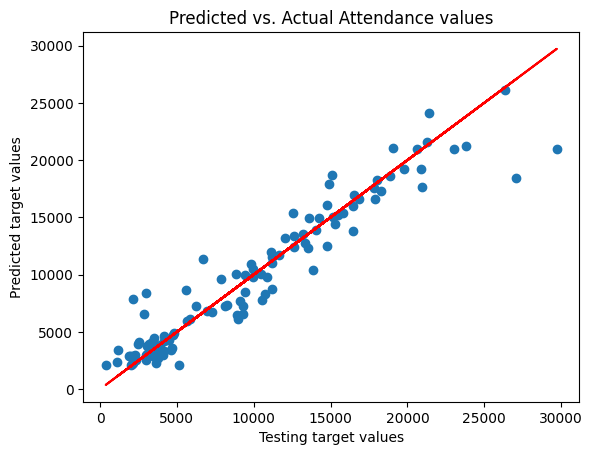

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_test_attendance, attendance_predictions)
ax.plot(y_test_attendance, y_test_attendance, color='red')
ax.set_xlabel('Testing target values')
ax.set_ylabel('Predicted target values')
ax.set_title('Predicted vs. Actual Attendance values')

## Make Predictions
We can now apply the model to an example value to see the correlation of weather conditions against the anticipated attendance.

In [33]:
"""
Weather Condition Groups
200 - Thunderstorm
300 - Drizzle
500 - Rain
600 - Snow
700 - Ash, Fog, Dust, Haze, Mist, Sand, Smoke, Squall, Tornado
800 - Clear, Clouds
"""

forecast_attendance =   10000     # average attendance rounded to 1000s
forecast_clouds_pct =   52        # average cloud coverage for the location
forecast_temperature =  61        # average temp for the location
forecast_humidity =     78        # average humidity for the location
forecast_wind_speed =   7         # average wind speed for the location

# In this example we will vary the weather condition for an average day.
# However, any feature can be adjusted to influence the model's output.
attendance = attendance_model.predict([
    #["weather_condition_group", "weather_clouds", "weather_temperature", "weather_humidity", "weather_wind_speed", "forecast_attendance"]
    [200, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance],
    [300, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance],
    [500, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance],
    [600, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance],
    [700, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance],
    [800, forecast_clouds_pct, forecast_temperature, forecast_humidity, forecast_wind_speed, forecast_attendance]
])

import math
print(f"Weather adjusted attendance using '{feature_names[1]}' of [{forecast_attendance}]:")
print(f"\tThunderstorm:\t\t\t{math.floor(attendance[0])}")
print(f"\tDrizzle:\t\t\t{math.floor(attendance[1])}")
print(f"\tRain:\t\t\t\t{math.floor(attendance[2])}")
print(f"\tSnow:\t\t\t\t{math.floor(attendance[3])}")
print(f"\tAtmosphere:\t\t\t{math.floor(attendance[4])}")
print(f"\tClear/Cloudy:\t\t\t{math.floor(attendance[5])}")

Weather adjusted attendance using 'weather_clouds' of [10000]:
	Thunderstorm:			8089
	Drizzle:			8343
	Rain:				8852
	Snow:				9106
	Atmosphere:			9361
	Clear/Cloudy:			9615
